# Lipid Droplet Assay

(turn in to shengkun.fang@fit.fraunhofer.de)

In this experiment, the influence of different compounds on the formation of so-called "lipid droplets” was investigated. "Lipid droplets" are one method for the human body to store fat. For the investigation, cell cultures were treated with different substances (compounds) and then incubated with various process parameters such as compound concentration, calcium concentration and treatment period.

Cell cultures are cultivated on plates (plates). Each plate in turn consists of 96 wells. The experimental arrangement of the plates is shown schematically in Figure 2. The challenge now is analyzing the effects of individual compounds and the effects of different parameters and to assess their influence on the formation of lipid droplets.

# Image Processing and Machine Learning

- The images from the lipid droplet assay were analyzed using [ZETA](https://www.fit.fraunhofer.de/en/fb/life/projects/zeta.html), an image and machine learning program provided by Fraunhofer FIT.
- which images were used for training and classification + why use such a variety

## Settings 1

1. FB Detection Notes

2. Cell Detection Ntes

3. Classification Notes

4. Evaluation Table

## Settings 2

1. FB Detection Notes

2. Cell Detection Ntes

3. Classification Notes

4. Evaluation Table

# Data Analysis

ZETA outputs the results of classification in a folder mirroring the folder structure of the input data. First, the individual CSV files from each of these directories are collated and annotated with information from the lipid droplet assay. The Image Path column is parsed to make annotations of the time interval, well number, and replicate number.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
from collections import defaultdict
import scipy
import scipy.stats
import ntpath
import itertools as itt
import matplotlib.pyplot as plt
from numpy import array as c

plt.rcParams['figure.figsize'] = 16, 9

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
base_in  = os.path.expanduser('~/Desktop/HCA 2016 Data/assay/resultPath')
base_out = os.path.expanduser('~/Desktop/HCA 2016 Data/')

In [3]:
intervals = 'VAC3-1H96H-20x', 'VAC3-24H96H-20X', 'VAC3-96H96H-20X'

compounds = {
    'Cpd 01': list(range(14, 24)),
    'Cpd 05': list(range(26, 36)),
    'Cpd 10': list(range(38, 48)),
    'Cpd 14': list(range(50, 60)),
    'Cpd 21': list(range(62, 72)),
    'Negative': list(range(74, 84))
}

positive_compounds = sorted(compound for compound in compounds if compound != 'Negative')

valid_wells = set(itt.chain.from_iterable(compounds.values()))

calcium = {}
ca = {}

for compound, cwells in compounds.items():
    for well in cwells[0:5]:
        calcium[well] = 'low'
    for well in cwells[5:10]:
        calcium[well] = 'high'
        
    for well in cwells:
        ca[well] = compound
        
concentrations = {
    -5: [14,15,16,26,27,28,38,39,40,50,51,52,19,20,21,31,32,33,43,44,45,55,56,57],
    -6: [17,18,29,30,41,42,53,54,22,23,34,35,46,47,57,59,62,67],
    -7: [63,68],
    -8: [64,69],
    -9: [65,70],
    -10: [66,71],
    0: list(range(74, 84))
}

concentrations = {well: conc for conc, wells in concentrations.items() for well in wells}

In [4]:
results_raw = {}

for interval in intervals:
    interval_path = os.path.join(base_in, interval)
    
    if os.path.exists(os.path.join(interval_path, '.DS_Store')):
        os.remove(os.path.join(interval_path, '.DS_Store'))
    
    for well_code in os.listdir(interval_path):
        well_path = os.path.join(interval_path, well_code)
        
        if not os.path.isdir(well_path):
            continue
        
        well = int(well_code[1:])
        if well not in valid_wells:
            continue
        
        data_path = min(f for f in os.listdir(well_path) if f.endswith('.csv'))
        df = pd.read_csv(os.path.join(well_path, data_path))

        images = df['Image Path'].map(lambda path: ntpath.basename(os.path.normpath(path)))

        image_well = images.map(lambda v: int(v[1:3]))
        time = images.map(lambda v: 1 if '1H96H' in v else (24 if '24H96H' in v else 96))
        replicate = images.map(lambda v: int(v[-5:-4]))

        df['Image Path'] = images
        df['Well'] = image_well
        df['Interval'] = time
        df['Replicate'] = replicate
        df['Calcium'] = image_well.map(calcium)
        df['Concentration'] = image_well.map(concentrations)
        df['Compound'] = image_well.map(ca)

        del df['Barcode ']
        del df['Site ']
        del df['Class 2 ']
        del df['Well ']
            
        results_raw[interval, well] = df
    
results_raw = pd.concat(list(results_raw.values()))
results_raw.to_csv(os.path.join(base_out, 'results_raw.csv'))

The rows of the CSV correspond to objects identified in each image. Each row has '1' in the column corresponding to its class. The entire CSV is aggregated to count how many objects were identified as lipid droplets for each interval, well, and replicate. The well numbers are then resolved to compound name, compound concentration, and calcium concentration.

In [ ]:
results_raw_imported = pd.from_csv(os.path.join(base_out, 'results_raw.csv'))

In [5]:
results_count = results_raw_imported.groupby(['Interval', 'Well', 'Replicate'])['Class 1 '].sum().reset_index()

results_count['Concentration'] = results_count['Well'].map(concentrations)
results_count['Compound'] = results_count['Well'].map(ca)
results_count['Calcium'] = results_count['Well'].map(calcium)

results_count['Count'] = results_count['Class 1 ']
del results_count['Class 1 ']

In [6]:
# grouping order
gbc = ['Interval', 'Compound', 'Calcium', 'Concentration']

The data is further aggregated to calculate the mean and variance of the count across the replicates of each interval, compound, and calcium concentration. Here, biological replicates of the same compound concentration across multiple wells and technical replicate images are aggregated.

In [7]:
results_grouping = results_count.groupby(gbc)['Count']
results_statistics = results_grouping.mean().reset_index()

results_statistics['Mean'] = results_statistics['Count']
del results_statistics['Count']
results_statistics['Std'] = results_grouping.std().reset_index()['Count']

The raw counts are reported for each compound with either high or low calcium concentration. The graphs show different lines for each concentration used and the x-axes show the time interval.

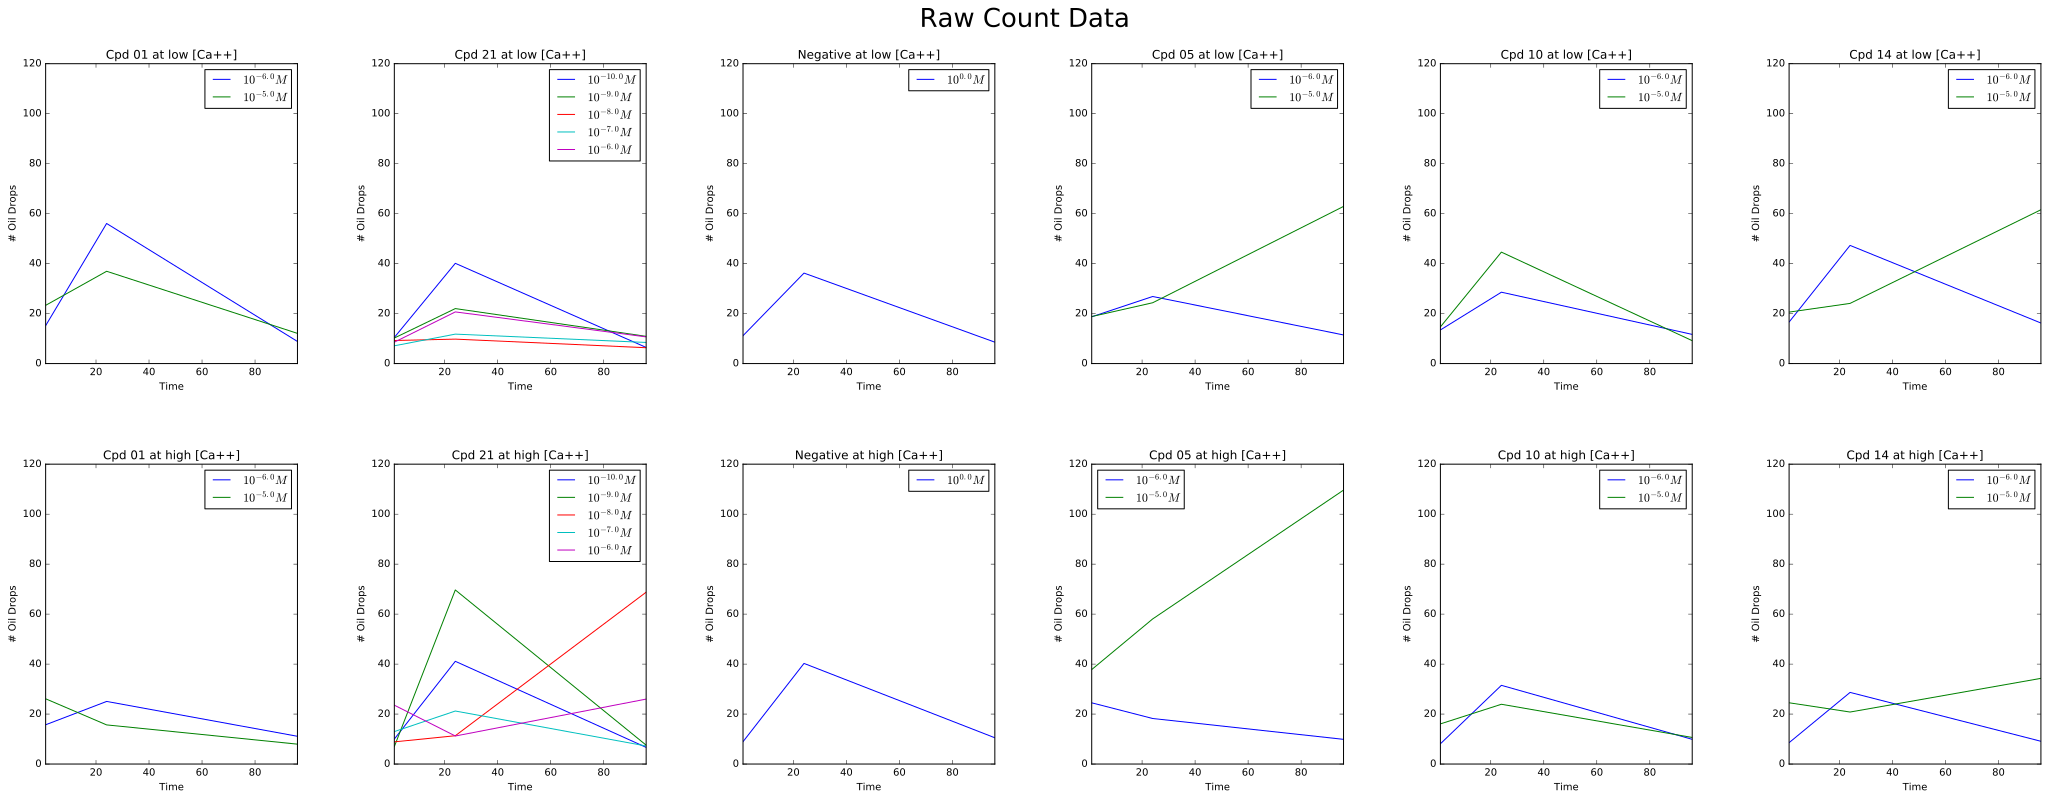

In [17]:
# see http://pandas.pydata.org/pandas-docs/stable/visualization.html#trellis-plotting-interface

fig, ax = plt.subplots(2, len(compounds), figsize=(30,12))

for i, compound in enumerate(compounds):
    a = results_statistics[results_statistics['Compound'] == compound]
    
    l = a[a['Calcium'] == 'low']
    h = a[a['Calcium'] == 'high']
    
    for concentration in sorted(set(h['Concentration'])):
        l[l['Concentration'] == concentration].plot(x='Interval', y='Mean', ax=ax[0, i], 
                                                    label="$10^{{{}}} M$".format(concentration))
        h[h['Concentration'] == concentration].plot(x='Interval', y='Mean', ax=ax[1, i], 
                                                    label="$10^{{{}}} M$".format(concentration))

    ax[0, i].set_title('{} at low [Ca++]'.format(compound))
    ax[1, i].set_title('{} at high [Ca++]'.format(compound))
    
for sax in ax.ravel():
    sax.set_ylabel('# Oil Drops')
    sax.set_xlabel('Time')
    sax.set_ylim([0, 120])

plt.suptitle('Raw Count Data', fontsize=26)
plt.tight_layout(pad=6.0)
plt.show()

Z-factor analysis and Welch's T-Test are used to quantify the effect of each compound compared to the negative control. The Z-factor is not mathematically robust, but is a common metric in high content screening. 

In [9]:
positive_test    = results_count[results_count['Compound'] != 'Negative']
negative_control = results_count[results_count['Compound'] == 'Negative']
t_test_results = []

for (i_interval, i_compound, i_calcium, i_concentration), i_df in positive_test.groupby(gbc):
    
    interval_slice = negative_control['Interval'] == i_interval
    calcium_slice  = negative_control['Calcium'] == i_calcium
    
    negative_counts = negative_control[c(interval_slice) & c(calcium_slice)]['Count']
    negative_mean = np.mean(negative_counts)
    negative_std = np.std(negative_counts)
      
    positive_counts = i_df['Count']
    positive_mean = np.mean(positive_counts)
    positive_std = np.std(positive_counts)
 
    welch_result = scipy.stats.ttest_ind(negative_counts, positive_counts, equal_var=False)
    z_factor = 1 - 3 * (positive_std + negative_std) / np.abs(positive_mean - negative_mean)
    
    mean_adjusted = positive_mean - negative_mean
    ratio_adjusted = np.log(positive_mean / negative_mean)
    
    t_test_results.append((i_interval, i_compound, i_calcium, i_concentration, z_factor, welch_result.pvalue, mean_adjusted, ratio_adjusted))    

t_test_results = pd.DataFrame(t_test_results, columns=gbc + ['Z_Factor', 'p', 'MeanAdjCount', 'RatioAdjCount'])

The p-values from Welch's T-test are corrected for multiple hypothesis testing using the Benjamini-Hochberg method.

In [10]:
# from http://stackoverflow.com/a/33532498/5775947
def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

t_test_results['mlp.adj'] = -np.log(p_adjust_bh(t_test_results['p']))

In [11]:
results = pd.merge(results_statistics, t_test_results, on=gbc, how='left')
results.to_csv(os.path.join(base_out, 'results.csv'))

In [28]:
def show(col, ylim=(-120,150), title="", ylab=''):
    fig, ax = plt.subplots(2, len(positive_compounds), figsize=(30, 12))
    for i, compound in enumerate(positive_compounds):
        a = results[results['Compound'] == compound]
       
        l = a[a['Calcium'] == 'low']
        h = a[a['Calcium'] == 'high']
    
        for concentration in sorted(set(h['Concentration'])):
            l[l['Concentration'] == concentration].plot(x='Interval', y=col, 
                                                        ax=ax[0, i], label="10^{{{}}} M".format(concentration))
            h[h['Concentration'] == concentration].plot(x='Interval', y=col, 
                                                        ax=ax[1, i], label="10^{{{}}} M".format(concentration))
    
    ax[0, i].set_title('Compound {} at low [Ca++]'.format(compound))
    ax[1, i].set_title('Compound {} at high [Ca++]'.format(compound))
    
    for s_ax in ax.ravel():
        s_ax.set_ylabel(ylab)
        s_ax.set_xlabel('Time')
        s_ax.set_ylim(ylim)
        s_ax.axhline(0, linestyle='--', color='grey', linewidth=1)    
    
    plt.suptitle(title, fontsize=26)
    plt.tight_layout(pad=6.0)
    plt.savefig(os.path.join(base_out, '{}.png'.format(col)))
    plt.show()

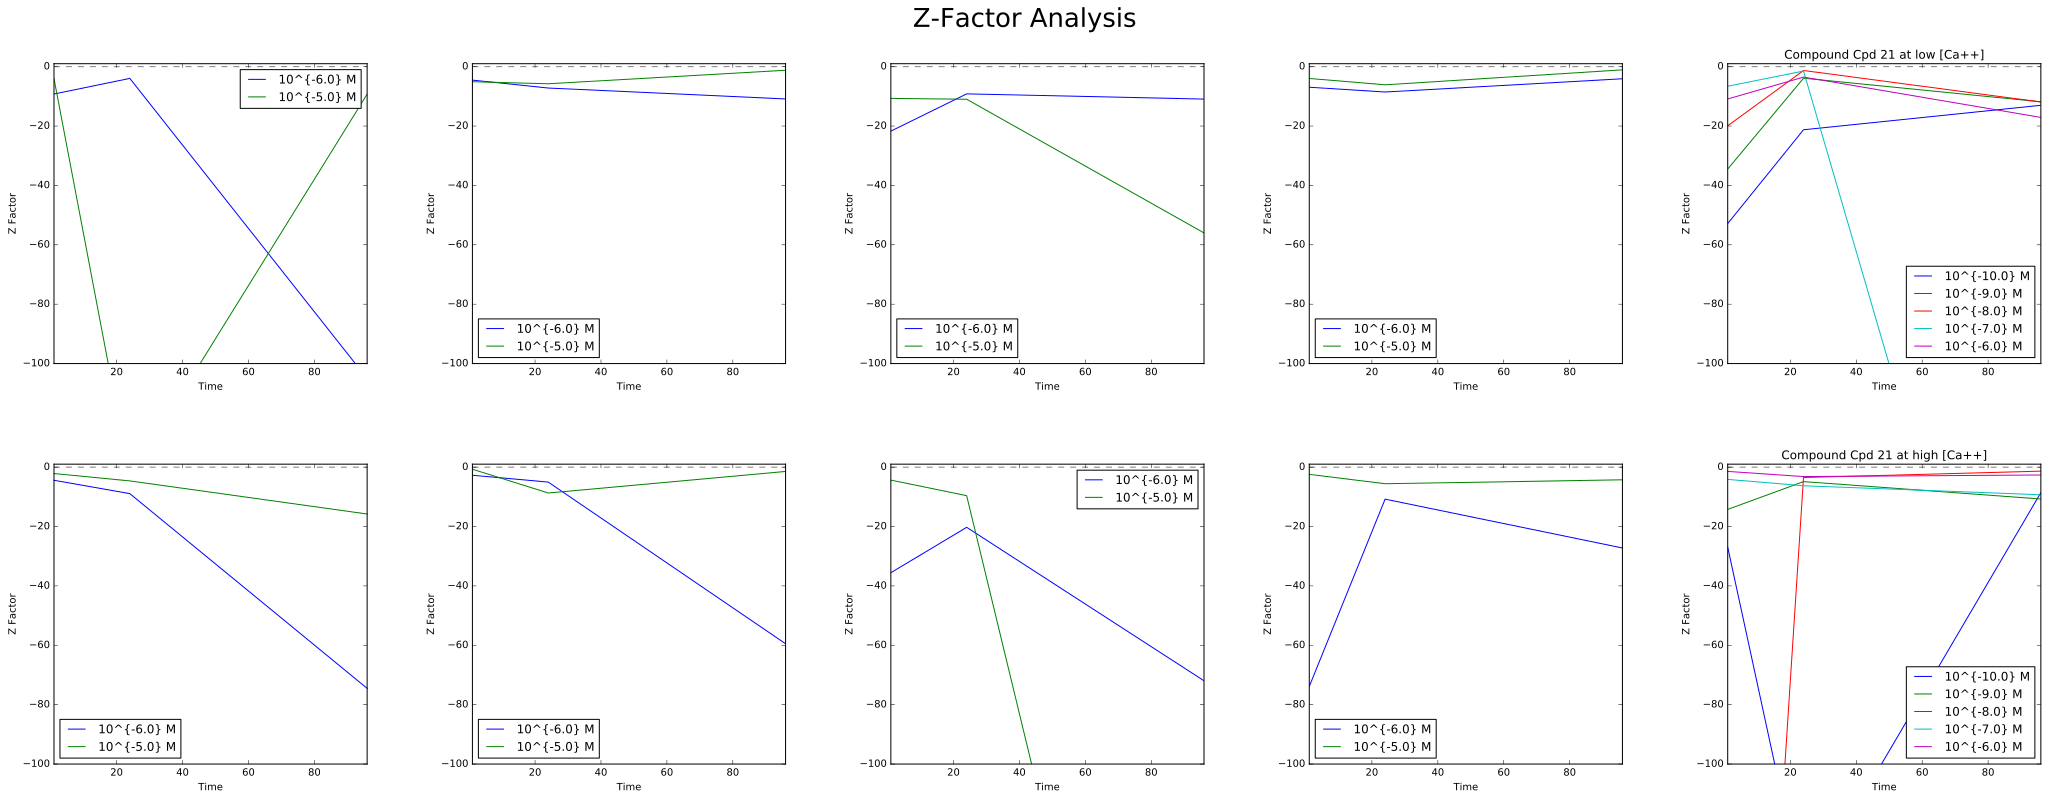

In [29]:
show('Z_Factor', ylim=(-100, 1), title="Z-Factor Analysis", ylab='Z Factor')

Z-factor values closer to 1 show good seperation between a positive test and a negative control. Values less than zero show poor resolution. In this assay, there was poor resolution in all samples due to the high amount of noise. The relative amount can be compared, and shows that some concentrations for Compound 5, Compound 14, and Compound 21 have good resolution from the negative control.

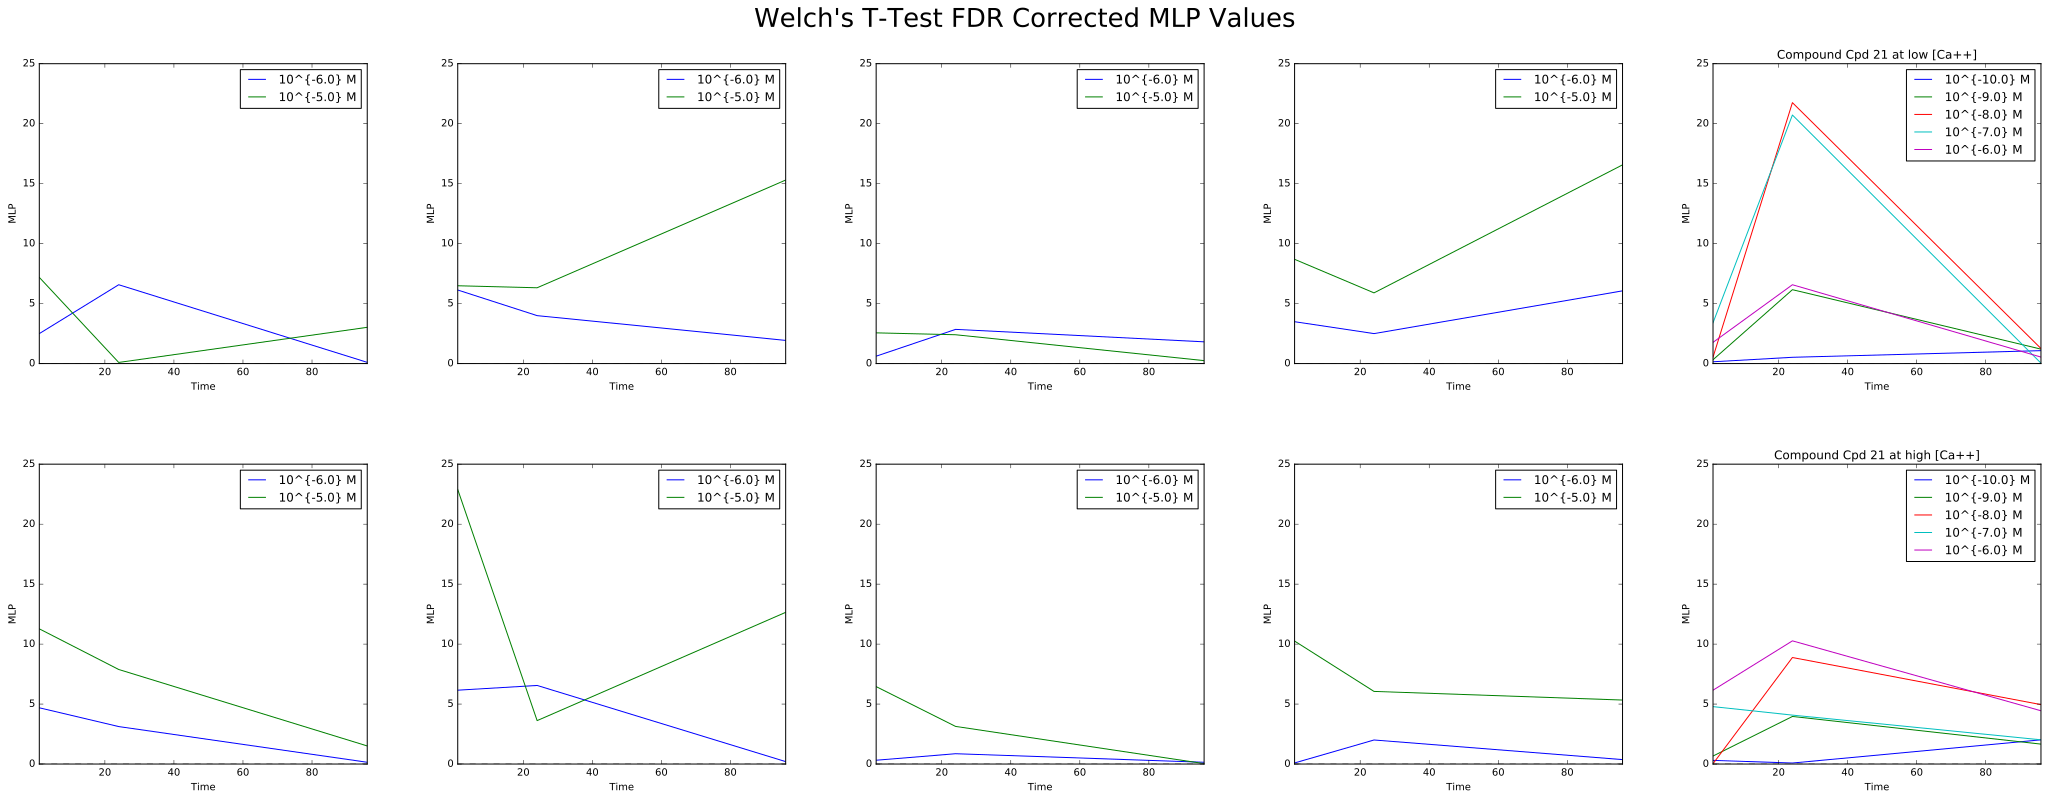

In [30]:
show('mlp.adj', ylim=(0, 25), title="Welch's T-Test FDR Corrected MLP Values", ylab='MLP')

Welch's T-test tests if the means of two samples are the same. The higher the minus-log-p-value, the more likely the means are not the same. The statistical analysis also shows the best separation for compounds 5 and 14 at 96 hours, and for Compound 21 at 24 hours. However, the effect on compound 21 was not monotonic with the increasing concentration, and might be noise.

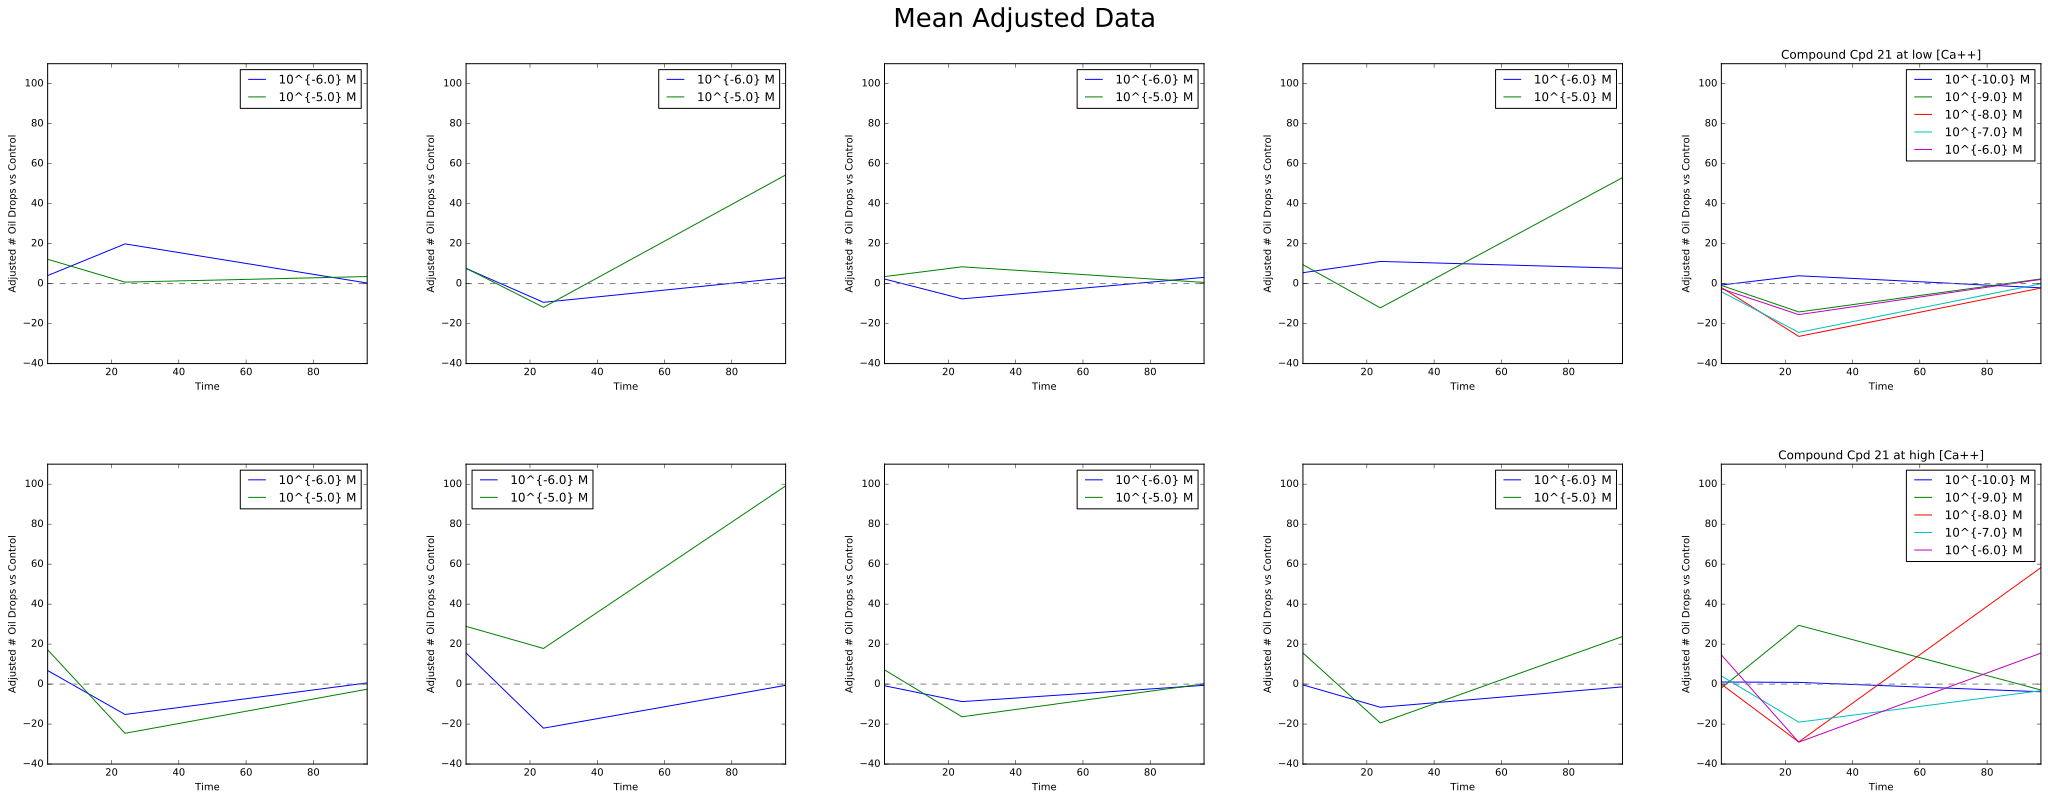

In [31]:
show('MeanAdjCount', ylim=(-40, 110), title="Mean Adjusted Data", ylab='Adjusted # Oil Drops vs Control')

In the lipid droplet assay, the negative control quantifies baseline lipid droplet formation rate. This value can be used to correct the results of the compounds and make different conditions' results comparable. One correction is to take the difference of the compound's effect and the negative control's effect.

This correction showed that compounds 5 and 14 had the largest effects at 96 hours, and that most compounds were ineffective at 1 and 24 hours.

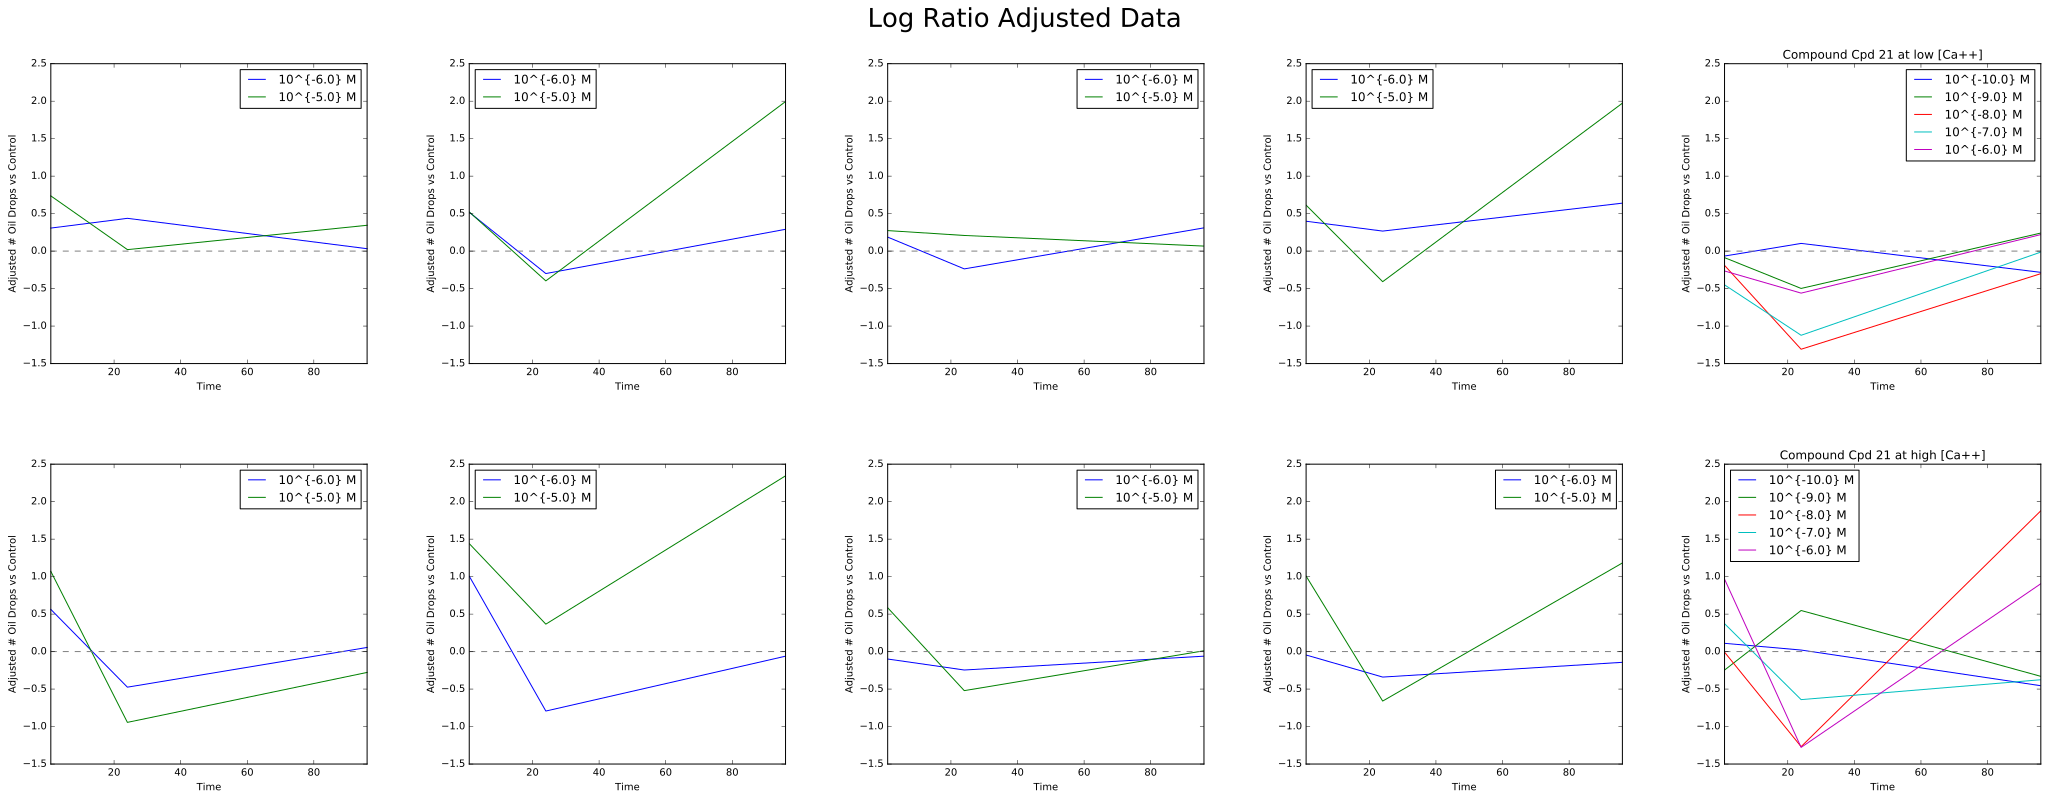

In [32]:
show('RatioAdjCount', ylim=(-1.5, 2.5), title='Log Ratio Adjusted Data', ylab='Adjusted # Oil Drops vs Control')

Another correction is to take the log of the ratio of the compound's effect to the negative control's effect. This makes interpretation easier by making all increasing effects positive, and decreasing effects negative. 

# Discussion

The effects of compounds at 24 hours were drastically smaller because the assay was an endpoint assay, and different plates were used for each time interval. The results for 24 hours had drastically more background noise in both the negative controls and the compounds' wells. This decreased the interpretability of the effect of the compounds on the assay at 24 hours. 

There could be many more contributing factors to why the active compounds only seemed active at 96 hours. One example might be that the compounds act through a slow mechanism, or are taken in very slowly to the cells. 